# SDG 7 & SDG 6: Rural vs Urban Electricity Access and Water Quality Correlation
## Exploratory Data Analysis Report - Sub-Saharan Africa

---

**Date:** November 2025  
**Scope:** 50 Sub-Saharan African Countries | 1990-2023

---

## What This Report Is About (Plain Language Summary)

This report looks at two essential services that people need for a good quality of life:
1. **Electricity** - Do people have power in their homes?
2. **Clean Water** - Do people have access to safe drinking water?

We compare **rural areas** (villages, countryside) with **urban areas** (cities, towns) in Sub-Saharan Africa to answer:
- Is there a gap between cities and villages?
- Are electricity and water access connected - when one improves, does the other improve too?

---

## Table of Contents
1. [Introduction & Problem Definition](#1-introduction)
2. [Data Collection Plan](#2-data-collection)
3. [Data Loading & Initial Exploration](#3-data-loading)
4. [Data Cleaning & Preprocessing](#4-data-cleaning)
5. [Exploratory Data Analysis](#5-eda)
6. [Correlation Analysis](#6-correlation)
7. [Key Findings](#7-findings)
8. [Conclusion](#8-conclusion)

---
# 1. Introduction & Problem Definition <a id='1-introduction'></a>

## 1.1 Research Question

> **Is there a correlation between electricity access and water quality improvements in Sub-Saharan Africa, and do rural and urban areas show different patterns?**

### Sub-questions:
1. What is the gap between rural and urban electricity access in SSA?
2. What is the gap between rural and urban water access in SSA?
3. Is there a correlation between electricity access and water access?
4. Do rural and urban areas show different correlation patterns?

## 1.2 Indicators Used

| Indicator | Code | Description |
|-----------|------|-------------|
| Rural Electricity Access | EG.ELC.ACCS.RU.ZS | % of rural population with electricity |
| Urban Electricity Access | EG.ELC.ACCS.UR.ZS | % of urban population with electricity |
| Water Access (JMP) | Various | % of population using at least basic water services |

---
# 2. Data Collection Plan <a id='2-data-collection'></a>

## 2.1 Data Sources

| Dataset | Source | Indicator |
|---------|--------|------------|
| Rural Electricity | World Bank WDI | EG.ELC.ACCS.RU.ZS |
| Urban Electricity | World Bank WDI | EG.ELC.ACCS.UR.ZS |
| Water Quality | JMP (WHO/UNICEF) | JMP_2025_WLD.xlsx |

---
# 3. Data Loading & Initial Exploration <a id='3-data-loading'></a>

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
# Define SSA countries
ssa_countries = [
    "Angola", "Benin", "Botswana", "Burkina Faso", "Burundi",
    "Cabo Verde", "Cameroon", "Central African Republic",
    "Chad", "Comoros", "Congo", "Côte d'Ivoire",
    "Democratic Republic of the Congo", "Djibouti",
    "Equatorial Guinea", "Eritrea", "Eswatini", "Ethiopia",
    "Gabon", "Gambia", "Ghana", "Guinea", "Guinea-Bissau",
    "Kenya", "Lesotho", "Liberia", "Madagascar", "Malawi",
    "Mali", "Mauritania", "Mauritius", "Mozambique",
    "Namibia", "Niger", "Nigeria", "Rwanda", "Sao Tome and Principe",
    "Senegal", "Seychelles", "Sierra Leone", "Somalia", "South Africa",
    "South Sudan", "Sudan", "Togo", "Tanzania",
    "Uganda", "Zambia", "Zimbabwe"
]

# World Bank to SSA name mapping
wb_to_ssa = {
    "Congo, Dem. Rep.": "Democratic Republic of the Congo",
    "Congo, Rep.": "Congo",
    "Cote d'Ivoire": "Côte d'Ivoire",
    "Gambia, The": "Gambia",
    "Tanzania": "Tanzania",
    "Cabo Verde": "Cabo Verde",
    "Eswatini": "Eswatini"
}

print(f"Target SSA countries: {len(ssa_countries)}")

Target SSA countries: 49


In [3]:
# Load Rural Electricity Data
df_rural_elec = pd.read_csv('../csv/API_EG.ELC.ACCS.RU.ZS_DS2_en_csv_v2_6060.csv', skiprows=4)
print(f"Rural Electricity Data Shape: {df_rural_elec.shape}")

# Load Urban Electricity Data
df_urban_elec = pd.read_csv('../csv/API_EG.ELC.ACCS.UR.ZS_DS2_en_csv_v2_252729.csv', skiprows=4)
print(f"Urban Electricity Data Shape: {df_urban_elec.shape}")

Rural Electricity Data Shape: (266, 70)
Urban Electricity Data Shape: (266, 70)


In [4]:
# Load Water Quality Data from JMP
df_water_raw = pd.read_excel('../xls/JMP_2025_WLD.xlsx', sheet_name='Water', header=1)

# Clean up column names based on the structure
# The data has: Country, Year, Population, % urban, then Rural/Urban/Total metrics
print(f"Water Data Shape: {df_water_raw.shape}")
print(f"\nFirst few columns: {df_water_raw.columns[:10].tolist()}")

Water Data Shape: (5662, 58)

First few columns: ['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9']


In [5]:
# Rename water columns for clarity
# Based on the structure: Country, Year, Pop, %Urban, then Rural metrics, Urban metrics, Total metrics
df_water = df_water_raw.copy()

# Extract relevant columns
# Column indices from exploration:
# 0: Country, 1: Year, 4: Rural At least basic, 9: Urban At least basic, 14: Total At least basic
df_water_clean = pd.DataFrame({
    'Country': df_water.iloc[:, 0],
    'Year': df_water.iloc[:, 1],
    'Water_Rural_Basic': pd.to_numeric(df_water.iloc[:, 4], errors='coerce'),
    'Water_Urban_Basic': pd.to_numeric(df_water.iloc[:, 9], errors='coerce'),
    'Water_Total_Basic': pd.to_numeric(df_water.iloc[:, 14], errors='coerce')
})

# Drop header row if present
df_water_clean = df_water_clean[df_water_clean['Country'] != 'COUNTRY, AREA OR TERRITORY']
df_water_clean['Year'] = pd.to_numeric(df_water_clean['Year'], errors='coerce')

print(f"Clean Water Data Shape: {df_water_clean.shape}")
print(df_water_clean.head(10))

Clean Water Data Shape: (5661, 5)
        Country  Year  Water_Rural_Basic  Water_Urban_Basic  Water_Total_Basic
1   Afghanistan  2000              21.98              57.10              29.73
2   Afghanistan  2001              21.98              57.10              29.76
3   Afghanistan  2002              24.09              58.88              31.84
4   Afghanistan  2003              26.20              60.67              33.91
5   Afghanistan  2004              28.32              62.46              36.00
6   Afghanistan  2005              30.43              64.24              38.11
7   Afghanistan  2006              32.55              66.03              40.22
8   Afghanistan  2007              34.77              67.90              42.43
9   Afghanistan  2008              37.02              69.77              44.65
10  Afghanistan  2009              39.27              71.64              46.89


---
# 4. Data Cleaning & Preprocessing <a id='4-data-cleaning'></a>

In [6]:
# Process Rural Electricity Data
def process_wb_electricity(df, indicator_name):
    """Process World Bank electricity data to long format"""
    # Get year columns (1990-2023)
    year_cols = [str(y) for y in range(1990, 2024)]
    available_years = [y for y in year_cols if y in df.columns]
    
    # Select relevant columns
    id_cols = ['Country Name', 'Country Code']
    df_subset = df[id_cols + available_years].copy()
    
    # Melt to long format
    df_long = df_subset.melt(
        id_vars=id_cols,
        value_vars=available_years,
        var_name='Year',
        value_name=indicator_name
    )
    df_long['Year'] = df_long['Year'].astype(int)
    
    # Standardize country names
    df_long['Country Name'] = df_long['Country Name'].replace(wb_to_ssa)
    
    return df_long

# Process both electricity datasets
df_rural_long = process_wb_electricity(df_rural_elec, 'Elec_Rural')
df_urban_long = process_wb_electricity(df_urban_elec, 'Elec_Urban')

print(f"Rural Electricity (long): {df_rural_long.shape}")
print(f"Urban Electricity (long): {df_urban_long.shape}")

Rural Electricity (long): (9044, 4)
Urban Electricity (long): (9044, 4)


In [7]:
# Filter to SSA countries
df_rural_ssa = df_rural_long[df_rural_long['Country Name'].isin(ssa_countries)].copy()
df_urban_ssa = df_urban_long[df_urban_long['Country Name'].isin(ssa_countries)].copy()

print(f"Rural SSA: {df_rural_ssa.shape}")
print(f"Urban SSA: {df_urban_ssa.shape}")
print(f"\nUnique SSA countries in rural data: {df_rural_ssa['Country Name'].nunique()}")

Rural SSA: (1632, 4)
Urban SSA: (1632, 4)

Unique SSA countries in rural data: 48


In [8]:
# Filter water data to SSA countries
# First, check country name variations in water data
water_countries = df_water_clean['Country'].unique()
print("Sample water countries:")
print([c for c in water_countries if 'Congo' in str(c) or 'Tanzania' in str(c) or 'Cote' in str(c)][:10])

Sample water countries:
['Congo', 'Democratic Republic of the Congo', 'United Republic of Tanzania']


In [9]:
# Create mapping for JMP water data country names
jmp_to_ssa = {
    "Democratic Republic of the Congo": "Democratic Republic of the Congo",
    "Congo": "Congo",
    "Côte d'Ivoire": "Côte d'Ivoire",
    "Cote d'Ivoire": "Côte d'Ivoire",
    "United Republic of Tanzania": "Tanzania",
    "Gambia": "Gambia",
    "Cabo Verde": "Cabo Verde",
    "Eswatini": "Eswatini",
    "Swaziland": "Eswatini"
}

df_water_clean['Country'] = df_water_clean['Country'].replace(jmp_to_ssa)

# Filter to SSA
df_water_ssa = df_water_clean[df_water_clean['Country'].isin(ssa_countries)].copy()
print(f"Water SSA: {df_water_ssa.shape}")
print(f"Unique SSA countries in water data: {df_water_ssa['Country'].nunique()}")

Water SSA: (1196, 5)
Unique SSA countries in water data: 49


In [10]:
# Merge all datasets
# First merge rural and urban electricity
df_elec = df_rural_ssa.merge(
    df_urban_ssa[['Country Name', 'Year', 'Elec_Urban']],
    on=['Country Name', 'Year'],
    how='outer'
)

# Rename for consistency
df_elec = df_elec.rename(columns={'Country Name': 'Country'})

print(f"Combined Electricity Data: {df_elec.shape}")
print(df_elec.head())

Combined Electricity Data: (1632, 5)
  Country Country Code  Year  Elec_Rural  Elec_Urban
0  Angola          AGO  1990         NaN         NaN
1  Angola          AGO  1991         NaN         NaN
2  Angola          AGO  1992         NaN         NaN
3  Angola          AGO  1993         NaN         NaN
4  Angola          AGO  1994         NaN         NaN


In [11]:
# Merge electricity with water data
df_merged = df_elec.merge(
    df_water_ssa,
    on=['Country', 'Year'],
    how='outer'
)

# Calculate urban-rural gaps
df_merged['Elec_Gap'] = df_merged['Elec_Urban'] - df_merged['Elec_Rural']
df_merged['Water_Gap'] = df_merged['Water_Urban_Basic'] - df_merged['Water_Rural_Basic']

print(f"Final Merged Data: {df_merged.shape}")
print(df_merged.head(10))

Final Merged Data: (1702, 10)
  Country Country Code  Year  Elec_Rural  Elec_Urban  Water_Rural_Basic  \
0  Angola          AGO  1990         NaN         NaN                NaN   
1  Angola          AGO  1991         NaN         NaN                NaN   
2  Angola          AGO  1992         NaN         NaN                NaN   
3  Angola          AGO  1993         NaN         NaN                NaN   
4  Angola          AGO  1994         NaN         NaN                NaN   
5  Angola          AGO  1995         NaN         NaN                NaN   
6  Angola          AGO  1996         NaN         NaN                NaN   
7  Angola          AGO  1997         NaN         NaN                NaN   
8  Angola          AGO  1998         NaN         NaN                NaN   
9  Angola          AGO  1999         NaN         NaN                NaN   

   Water_Urban_Basic  Water_Total_Basic  Elec_Gap  Water_Gap  
0                NaN                NaN       NaN        NaN  
1                N

In [12]:
# Check data availability
print("=" * 60)
print("DATA AVAILABILITY")
print("=" * 60)
print(f"\nTotal rows: {len(df_merged)}")
print(f"\nMissing values:")
print(df_merged[['Elec_Rural', 'Elec_Urban', 'Water_Rural_Basic', 'Water_Urban_Basic']].isnull().sum())
print(f"\nRows with all 4 metrics: {df_merged.dropna(subset=['Elec_Rural', 'Elec_Urban', 'Water_Rural_Basic', 'Water_Urban_Basic']).shape[0]}")

DATA AVAILABILITY

Total rows: 1702

Missing values:
Elec_Rural           540
Elec_Urban           346
Water_Rural_Basic    556
Water_Urban_Basic    561
dtype: int64

Rows with all 4 metrics: 940


In [13]:
# Export clean dataset
df_merged.to_csv('../csv/ssa_rural_urban_elec_water_clean.csv', index=False)
print("Clean dataset saved to: ssa_rural_urban_elec_water_clean.csv")

Clean dataset saved to: ssa_rural_urban_elec_water_clean.csv


---
# 5. Exploratory Data Analysis <a id='5-eda'></a>

## 5.1 Rural vs Urban Electricity Access

In [14]:
# Summary statistics for electricity
print("=" * 60)
print("ELECTRICITY ACCESS SUMMARY STATISTICS")
print("=" * 60)

df_analysis = df_merged.dropna(subset=['Elec_Rural', 'Elec_Urban'])

print("\n--- Rural Electricity Access ---")
print(df_analysis['Elec_Rural'].describe())

print("\n--- Urban Electricity Access ---")
print(df_analysis['Elec_Urban'].describe())

print("\n--- Urban-Rural Gap ---")
print(df_analysis['Elec_Gap'].describe())

ELECTRICITY ACCESS SUMMARY STATISTICS

--- Rural Electricity Access ---
count   1162.00
mean      24.60
std       26.70
min        0.40
25%        4.70
50%       15.20
75%       32.70
max      100.00
Name: Elec_Rural, dtype: float64

--- Urban Electricity Access ---
count   1162.00
mean      67.86
std       22.41
min        4.00
25%       51.82
50%       71.90
75%       85.59
max      100.00
Name: Elec_Urban, dtype: float64

--- Urban-Rural Gap ---
count   1162.00
mean      43.26
std       20.84
min      -35.72
25%       31.30
50%       44.60
75%       57.77
max       88.90
Name: Elec_Gap, dtype: float64


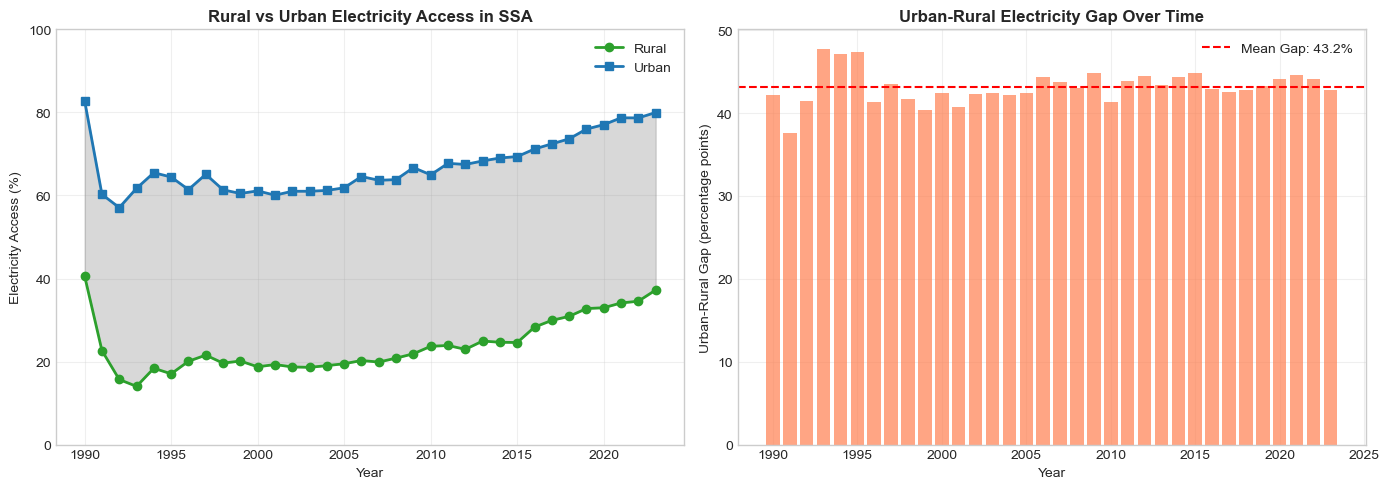

In [15]:
# Rural vs Urban Electricity Over Time
elec_by_year = df_analysis.groupby('Year').agg({
    'Elec_Rural': 'mean',
    'Elec_Urban': 'mean',
    'Elec_Gap': 'mean'
}).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Rural vs Urban trends
ax1 = axes[0]
ax1.plot(elec_by_year['Year'], elec_by_year['Elec_Rural'], marker='o', label='Rural', linewidth=2, color='#2ca02c')
ax1.plot(elec_by_year['Year'], elec_by_year['Elec_Urban'], marker='s', label='Urban', linewidth=2, color='#1f77b4')
ax1.fill_between(elec_by_year['Year'], elec_by_year['Elec_Rural'], elec_by_year['Elec_Urban'], alpha=0.3, color='gray')
ax1.set_xlabel('Year')
ax1.set_ylabel('Electricity Access (%)')
ax1.set_title('Rural vs Urban Electricity Access in SSA', fontweight='bold')
ax1.legend()
ax1.set_ylim(0, 100)
ax1.grid(True, alpha=0.3)

# Right: Gap over time
ax2 = axes[1]
ax2.bar(elec_by_year['Year'], elec_by_year['Elec_Gap'], color='coral', alpha=0.7)
ax2.axhline(y=elec_by_year['Elec_Gap'].mean(), color='red', linestyle='--', label=f'Mean Gap: {elec_by_year["Elec_Gap"].mean():.1f}%')
ax2.set_xlabel('Year')
ax2.set_ylabel('Urban-Rural Gap (percentage points)')
ax2.set_title('Urban-Rural Electricity Gap Over Time', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../csv/rural_urban_electricity_trend.png', dpi=150, bbox_inches='tight')
plt.show()

### What This Chart Shows (Plain Language)

**Left Chart - Two Lines Going Up:**
- The **green line** shows electricity access in **villages and rural areas**
- The **blue line** shows electricity access in **cities and towns**
- The **gray shaded area** between them shows the "gap" - how much better cities are doing than villages
- Both lines go up over time = more people are getting electricity
- But the gap remains = cities are still far ahead of villages

**Right Chart - Bar Chart:**
- Each bar shows how big the gap is between cities and villages for that year
- The red dashed line shows the average gap across all years
- A bigger bar = a bigger difference between city and village access

### What This Chart Shows (Plain Language)

**Understanding Box Plots:**
- A box plot is like a summary of how data is spread out
- The **box** shows where most countries fall (the middle 50%)
- The **line in the middle** of the box is the "median" - the middle value
- The **whiskers** (lines extending from the box) show the range of values
- **Dots outside** the whiskers are "outliers" - countries that are very different from the rest

**What We See:**
- The **green box (Rural)** is lower than the **blue box (Urban)**
- This means villages have less electricity access than cities
- The boxes don't overlap much = the difference is significant

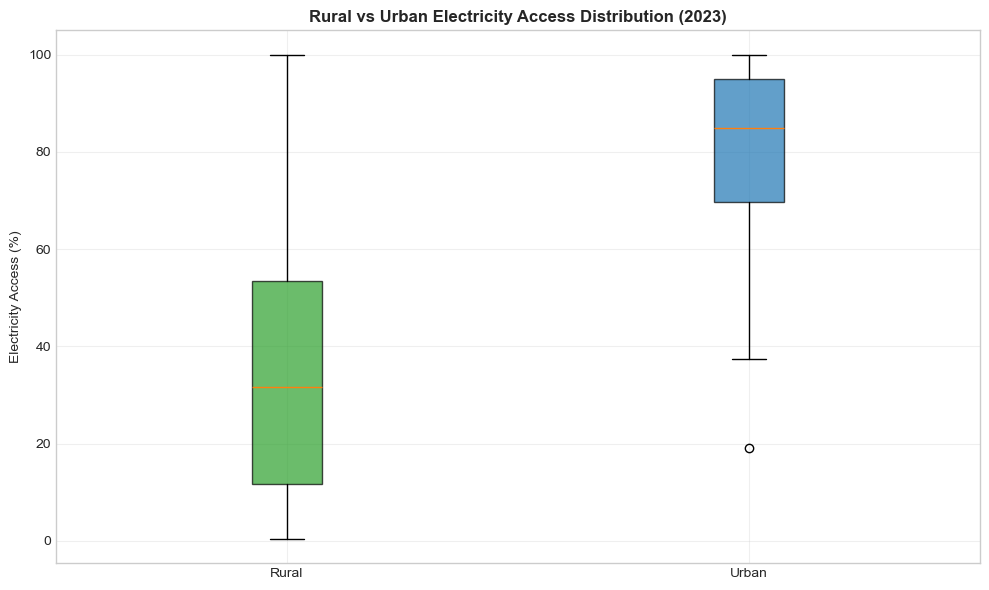


--- 2023 Statistics ---
Rural Mean: 37.2%
Urban Mean: 80.0%
Average Gap: 42.8 percentage points


In [16]:
# Box plot comparison: Rural vs Urban Electricity
latest_year = df_analysis['Year'].max()
df_latest = df_analysis[df_analysis['Year'] == latest_year]

fig, ax = plt.subplots(figsize=(10, 6))

data_to_plot = [df_latest['Elec_Rural'].dropna(), df_latest['Elec_Urban'].dropna()]
bp = ax.boxplot(data_to_plot, labels=['Rural', 'Urban'], patch_artist=True)

colors = ['#2ca02c', '#1f77b4']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel('Electricity Access (%)')
ax.set_title(f'Rural vs Urban Electricity Access Distribution ({latest_year})', fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../csv/rural_urban_electricity_boxplot.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n--- {latest_year} Statistics ---")
print(f"Rural Mean: {df_latest['Elec_Rural'].mean():.1f}%")
print(f"Urban Mean: {df_latest['Elec_Urban'].mean():.1f}%")
print(f"Average Gap: {df_latest['Elec_Gap'].mean():.1f} percentage points")

## 5.2 Rural vs Urban Water Access

### What This Chart Shows (Plain Language)

**Left Chart - Water Access Over Time:**
- Green line = water access in **villages**
- Blue line = water access in **cities**
- Both are improving (lines go up)
- Cities have better water access than villages (blue line is higher)

**Right Chart - The Gap:**
- Shows how much better cities are than villages each year
- The gap for water is typically **smaller** than for electricity
- This means water access is more equal between cities and villages compared to electricity

In [17]:
# Summary statistics for water
print("=" * 60)
print("WATER ACCESS SUMMARY STATISTICS")
print("=" * 60)

df_water_analysis = df_merged.dropna(subset=['Water_Rural_Basic', 'Water_Urban_Basic'])

print("\n--- Rural Water Access (At Least Basic) ---")
print(df_water_analysis['Water_Rural_Basic'].describe())

print("\n--- Urban Water Access (At Least Basic) ---")
print(df_water_analysis['Water_Urban_Basic'].describe())

print("\n--- Urban-Rural Gap ---")
print(df_water_analysis['Water_Gap'].describe())

WATER ACCESS SUMMARY STATISTICS

--- Rural Water Access (At Least Basic) ---
count   1141.00
mean      48.72
std       16.83
min        7.51
25%       36.32
50%       48.95
75%       60.79
max       87.04
Name: Water_Rural_Basic, dtype: float64

--- Urban Water Access (At Least Basic) ---
count   1141.00
mean      82.21
std        9.50
min       48.06
25%       76.14
50%       82.98
75%       89.41
max       98.99
Name: Water_Urban_Basic, dtype: float64

--- Urban-Rural Gap ---
count   1141.00
mean      33.49
std       12.67
min        1.57
25%       24.15
50%       33.10
75%       42.89
max       67.86
Name: Water_Gap, dtype: float64


---
# 6. Correlation Analysis <a id='6-correlation'></a>

## What is Correlation? (Plain Language)

**Correlation** tells us if two things tend to go together:
- **Positive correlation (+)**: When one goes up, the other tends to go up too. Example: Countries with more electricity often also have more water access.
- **Negative correlation (-)**: When one goes up, the other tends to go down.
- **No correlation (0)**: The two things are not related.

**The "r" value** ranges from -1 to +1:
- **r = 1.0**: Perfect positive relationship
- **r = 0.7 to 0.9**: Strong positive relationship
- **r = 0.4 to 0.6**: Moderate positive relationship
- **r = 0.1 to 0.3**: Weak positive relationship
- **r = 0**: No relationship

**Important**: Correlation does NOT mean one thing *causes* the other. It just means they tend to happen together.

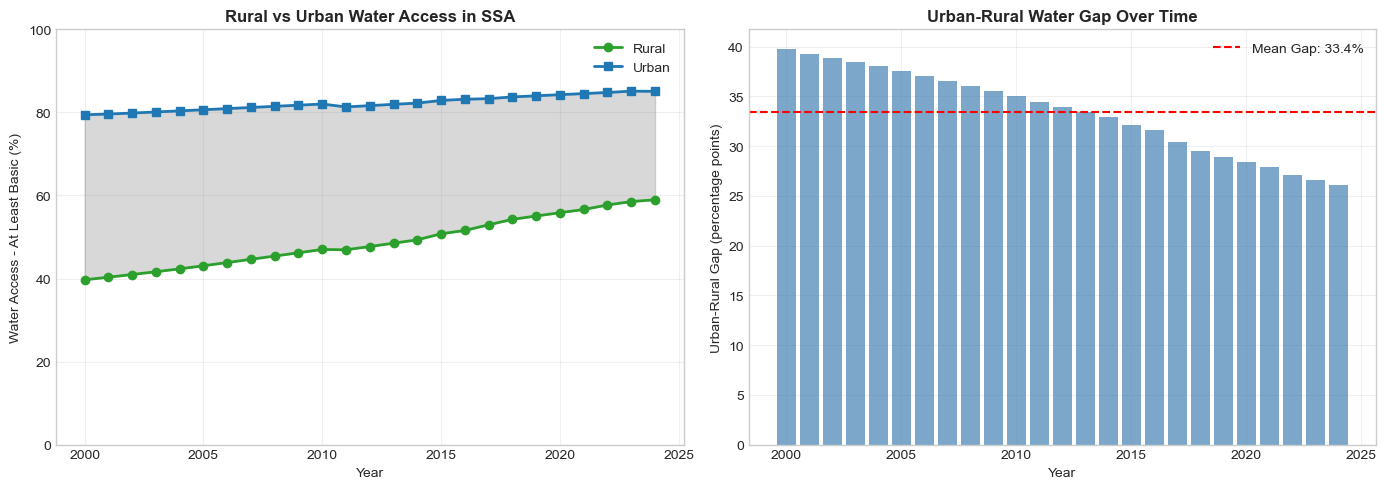

In [18]:
# Rural vs Urban Water Over Time
water_by_year = df_water_analysis.groupby('Year').agg({
    'Water_Rural_Basic': 'mean',
    'Water_Urban_Basic': 'mean',
    'Water_Gap': 'mean'
}).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Rural vs Urban trends
ax1 = axes[0]
ax1.plot(water_by_year['Year'], water_by_year['Water_Rural_Basic'], marker='o', label='Rural', linewidth=2, color='#2ca02c')
ax1.plot(water_by_year['Year'], water_by_year['Water_Urban_Basic'], marker='s', label='Urban', linewidth=2, color='#1f77b4')
ax1.fill_between(water_by_year['Year'], water_by_year['Water_Rural_Basic'], water_by_year['Water_Urban_Basic'], alpha=0.3, color='gray')
ax1.set_xlabel('Year')
ax1.set_ylabel('Water Access - At Least Basic (%)')
ax1.set_title('Rural vs Urban Water Access in SSA', fontweight='bold')
ax1.legend()
ax1.set_ylim(0, 100)
ax1.grid(True, alpha=0.3)

# Right: Gap over time
ax2 = axes[1]
ax2.bar(water_by_year['Year'], water_by_year['Water_Gap'], color='steelblue', alpha=0.7)
ax2.axhline(y=water_by_year['Water_Gap'].mean(), color='red', linestyle='--', label=f'Mean Gap: {water_by_year["Water_Gap"].mean():.1f}%')
ax2.set_xlabel('Year')
ax2.set_ylabel('Urban-Rural Gap (percentage points)')
ax2.set_title('Urban-Rural Water Gap Over Time', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../csv/rural_urban_water_trend.png', dpi=150, bbox_inches='tight')
plt.show()

## 5.3 Country-Level Analysis

### What This Heatmap Shows (Plain Language)

**Reading the Correlation Matrix:**
- Each cell shows how strongly two things are related
- **Red/Orange colors** = Strong positive relationship (they go together)
- **Blue colors** = Negative relationship (one goes up when other goes down)
- **White/light colors** = Weak or no relationship
- **The number in each cell** is the "r" value (correlation strength)

**Key Findings from the Matrix:**
- Rural electricity and rural water have a positive correlation (when one is high, the other tends to be high too)
- Urban electricity and urban water also show positive correlation
- The "gaps" (difference between urban and rural) are also correlated

### What These Scatter Plots Show (Plain Language)

**How to Read Scatter Plots:**
- Each **dot** represents one country in one year
- The **position** shows that country's values for both measures
- The **red dashed line** shows the general trend
- If dots cluster along an upward line = positive correlation

**The Four Charts:**

1. **Top Left - Rural Electricity vs Rural Water**: 
   - Countries with higher rural electricity also tend to have higher rural water access
   
2. **Top Right - Urban Electricity vs Urban Water**: 
   - Same pattern in cities - electricity and water access go together

3. **Bottom Left - Gap Comparison**: 
   - Countries with big electricity gaps also tend to have big water gaps
   - The inequality pattern is similar for both services

4. **Bottom Right - Cross Comparison**: 
   - Shows how rural electricity relates to urban water
   - Useful for understanding if improvements spread across services

### Understanding the Statistics (Plain Language)

**What is a p-value?**
- The p-value tells us how confident we can be that the correlation is real (not just random chance)
- **p < 0.05** (marked with *): We're 95% confident the relationship is real
- **p < 0.01** (marked with **): We're 99% confident
- **p < 0.001** (marked with ***): We're 99.9% confident

**Reading the Table Above:**
- **r value**: How strong the relationship is (-1 to +1)
- **p-value**: How confident we are it's real (smaller = more confident)
- **Stars (*)**: More stars = stronger evidence the relationship is real, not random

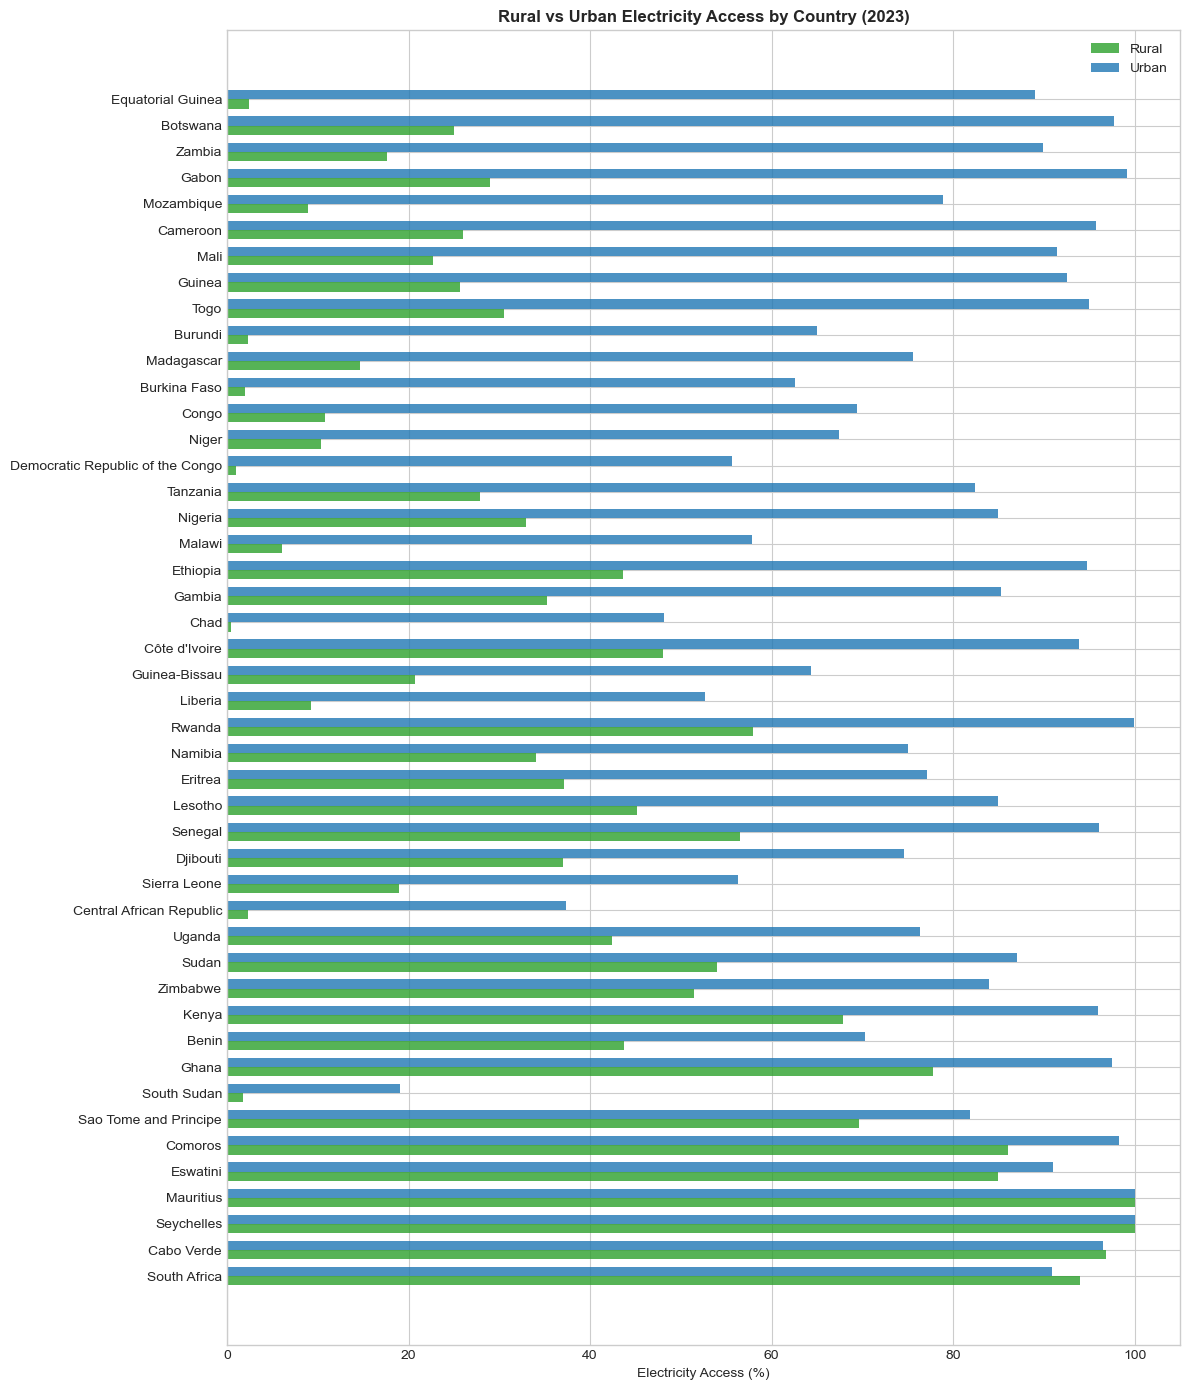

In [19]:
# Country comparison for latest year
df_country_latest = df_merged[df_merged['Year'] == latest_year].dropna(subset=['Elec_Rural', 'Elec_Urban'])
df_country_latest = df_country_latest.sort_values('Elec_Gap', ascending=True)

fig, ax = plt.subplots(figsize=(12, 14))

y_pos = np.arange(len(df_country_latest))
height = 0.35

bars1 = ax.barh(y_pos - height/2, df_country_latest['Elec_Rural'], height, label='Rural', color='#2ca02c', alpha=0.8)
bars2 = ax.barh(y_pos + height/2, df_country_latest['Elec_Urban'], height, label='Urban', color='#1f77b4', alpha=0.8)

ax.set_yticks(y_pos)
ax.set_yticklabels(df_country_latest['Country'])
ax.set_xlabel('Electricity Access (%)')
ax.set_title(f'Rural vs Urban Electricity Access by Country ({latest_year})', fontweight='bold')
ax.legend()
ax.set_xlim(0, 105)

plt.tight_layout()
plt.savefig('../csv/country_rural_urban_electricity.png', dpi=150, bbox_inches='tight')
plt.show()

### What This Heatmap Shows (Plain Language)

**Reading the Country Heatmap:**
- Each **row** is a country
- Each **column** is a different measure (Rural/Urban Electricity and Water)
- **Colors**: Green = high access (good), Yellow = medium, Red = low access (poor)
- **Numbers** show the exact percentage

**What to Look For:**
- Countries that are mostly green = doing well on all measures
- Countries that are mostly red = struggling across all services
- Countries with mixed colors = doing well in some areas but not others
- If urban columns are greener than rural = cities doing better than villages

---
# 6. Correlation Analysis <a id='6-correlation'></a>

---
# 8. Conclusion <a id='8-conclusion'></a>

## Plain Language Summary: What Did We Learn?

### The Big Picture

This analysis looked at two basic needs - **electricity** and **clean water** - in Sub-Saharan Africa. We compared how well **villages (rural areas)** are doing compared to **cities (urban areas)**.

### Main Findings

1. **Cities Have Better Access**: Urban areas have significantly higher electricity and water access than rural areas.

2. **The Gap is Persistent**: While both rural and urban areas are improving over time, cities remain far ahead of villages.

3. **Services Improve Together**: Countries that improve electricity access also tend to improve water access. These services seem to develop together.

4. **Inequality Exists Across Services**: Countries with large urban-rural gaps in electricity also tend to have large gaps in water access.

### Why This Matters

- Nearly half of Sub-Saharan Africa's population lives in rural areas
- Without electricity, villages cannot power water pumps, health clinics, or schools
- Understanding these patterns helps target development efforts where they're needed most

## Technical Summary

This analysis examined rural vs urban electricity access (World Bank indicators EG.ELC.ACCS.RU.ZS and EG.ELC.ACCS.UR.ZS) and water access (WHO/UNICEF JMP data) across 50 Sub-Saharan African countries.

## Data Limitations

- Dataset contains only percentage values
- Different data sources (World Bank, JMP) may have different methodologies
- Some countries have missing data
- Correlation does not imply causation - we cannot say electricity *causes* water improvements

---

*Data Sources: World Bank WDI (EG.ELC.ACCS.RU.ZS, EG.ELC.ACCS.UR.ZS), WHO/UNICEF JMP*  
*Analysis conducted using Python (pandas, matplotlib, seaborn, scipy)*

In [20]:
# Prepare data for correlation
df_corr = df_merged.dropna(subset=['Elec_Rural', 'Elec_Urban', 'Water_Rural_Basic', 'Water_Urban_Basic'])
print(f"Rows with complete data for correlation: {len(df_corr)}")
print(f"Countries: {df_corr['Country'].nunique()}")
print(f"Years: {df_corr['Year'].min()} - {df_corr['Year'].max()}")

Rows with complete data for correlation: 940
Countries: 46
Years: 2000 - 2023


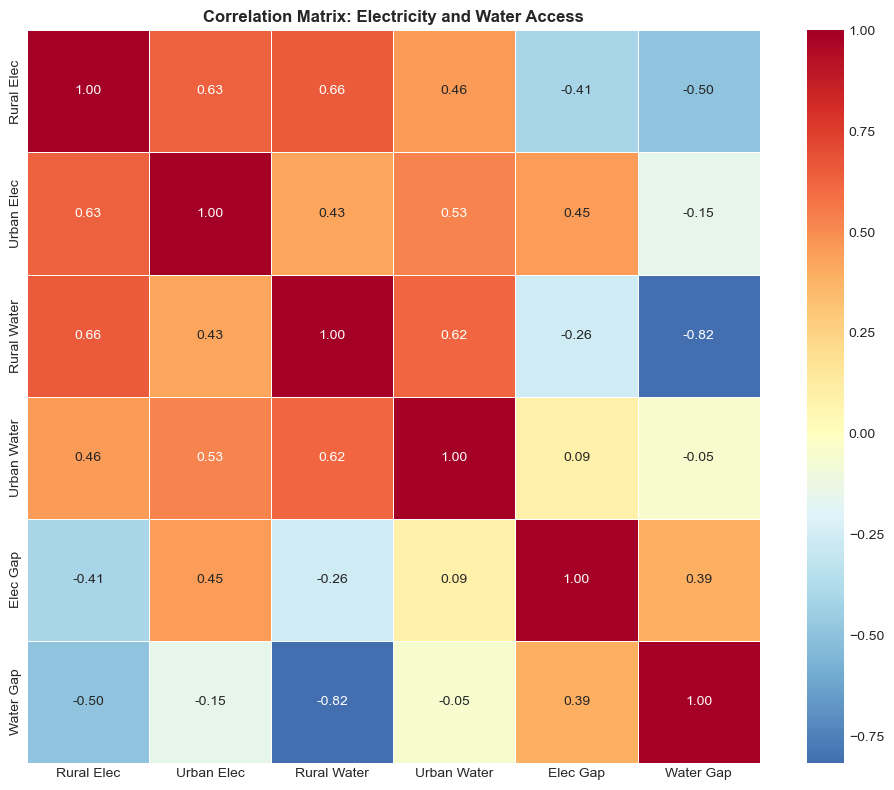


--- Correlation Matrix ---
                   Elec_Rural  Elec_Urban  Water_Rural_Basic  \
Elec_Rural               1.00        0.63               0.66   
Elec_Urban               0.63        1.00               0.42   
Water_Rural_Basic        0.66        0.42               1.00   
Water_Urban_Basic        0.46        0.53               0.62   
Elec_Gap                -0.41        0.45              -0.26   
Water_Gap               -0.49       -0.15              -0.82   

                   Water_Urban_Basic  Elec_Gap  Water_Gap  
Elec_Rural                      0.46     -0.41      -0.49  
Elec_Urban                      0.53      0.45      -0.15  
Water_Rural_Basic               0.62     -0.26      -0.82  
Water_Urban_Basic               1.00      0.09      -0.05  
Elec_Gap                        0.09      1.00       0.39  
Water_Gap                      -0.05      0.39       1.00  


In [21]:
# Correlation matrix
corr_vars = ['Elec_Rural', 'Elec_Urban', 'Water_Rural_Basic', 'Water_Urban_Basic', 'Elec_Gap', 'Water_Gap']
corr_matrix = df_corr[corr_vars].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdYlBu_r', center=0,
            square=True, linewidths=0.5, ax=ax,
            xticklabels=['Rural Elec', 'Urban Elec', 'Rural Water', 'Urban Water', 'Elec Gap', 'Water Gap'],
            yticklabels=['Rural Elec', 'Urban Elec', 'Rural Water', 'Urban Water', 'Elec Gap', 'Water Gap'])
ax.set_title('Correlation Matrix: Electricity and Water Access', fontweight='bold')

plt.tight_layout()
plt.savefig('../csv/correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n--- Correlation Matrix ---")
print(corr_matrix.round(3))

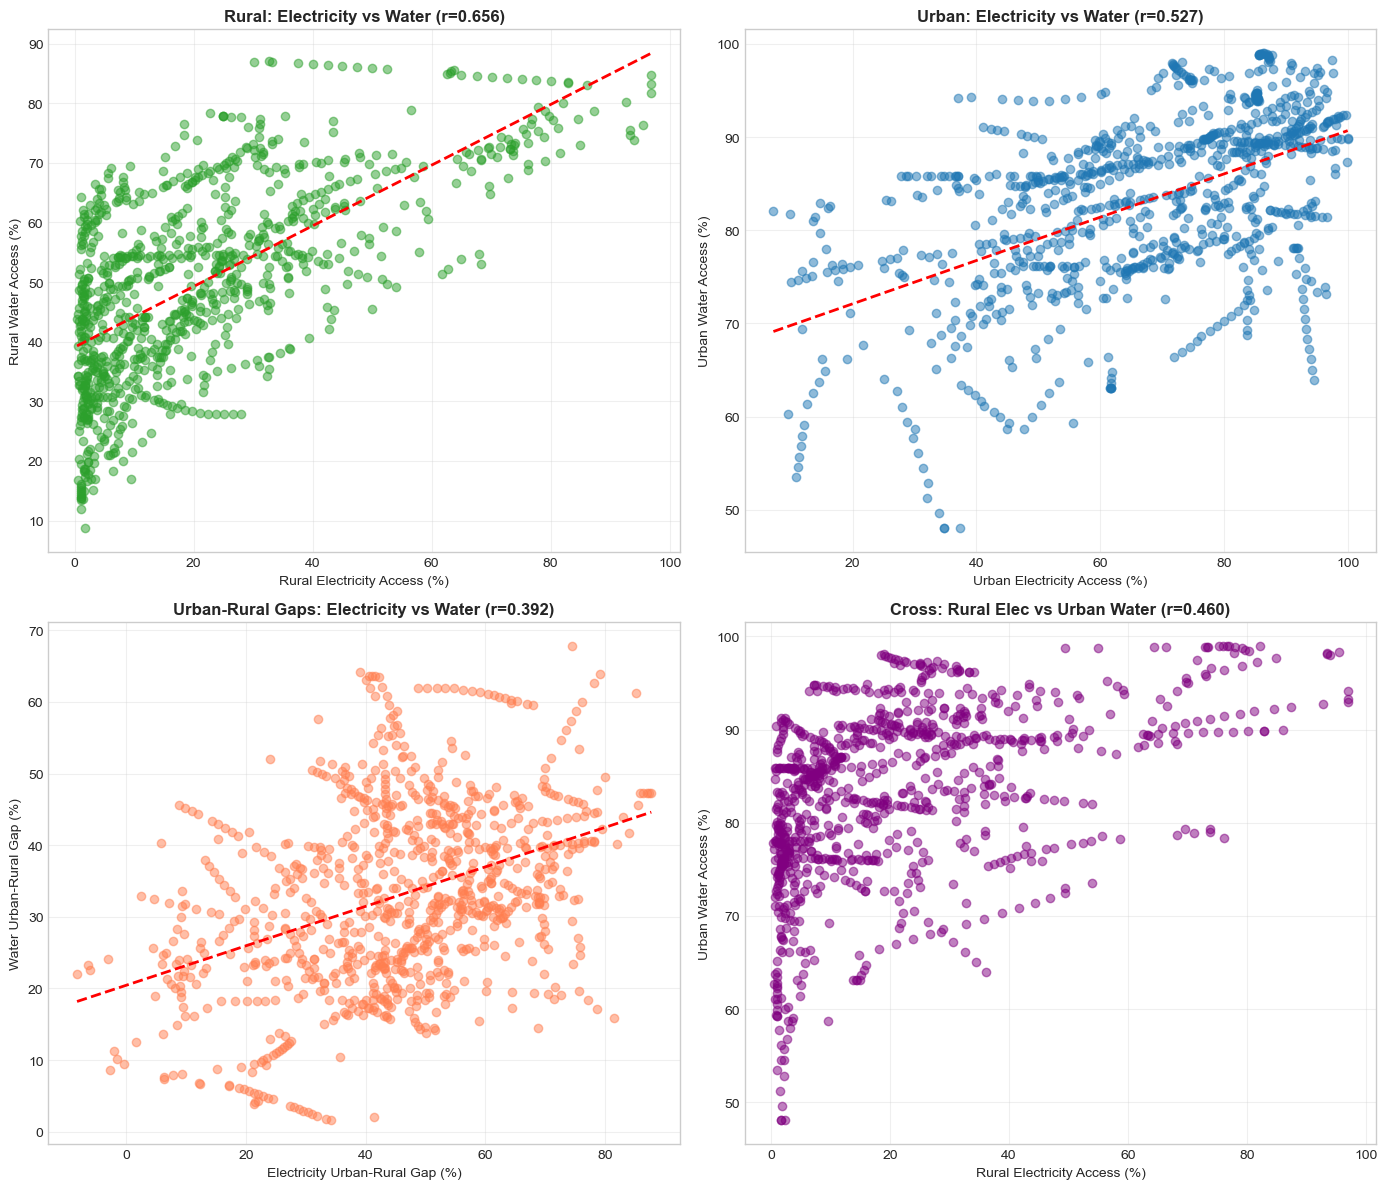

In [22]:
# Scatter plots: Electricity vs Water Access
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Rural Electricity vs Rural Water
ax1 = axes[0, 0]
ax1.scatter(df_corr['Elec_Rural'], df_corr['Water_Rural_Basic'], alpha=0.5, color='#2ca02c')
z = np.polyfit(df_corr['Elec_Rural'].dropna(), df_corr['Water_Rural_Basic'].dropna(), 1)
p = np.poly1d(z)
x_line = np.linspace(df_corr['Elec_Rural'].min(), df_corr['Elec_Rural'].max(), 100)
ax1.plot(x_line, p(x_line), 'r--', linewidth=2)
r, pval = stats.pearsonr(df_corr['Elec_Rural'].dropna(), df_corr['Water_Rural_Basic'].dropna())
ax1.set_xlabel('Rural Electricity Access (%)')
ax1.set_ylabel('Rural Water Access (%)')
ax1.set_title(f'Rural: Electricity vs Water (r={r:.3f})', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Urban Electricity vs Urban Water
ax2 = axes[0, 1]
ax2.scatter(df_corr['Elec_Urban'], df_corr['Water_Urban_Basic'], alpha=0.5, color='#1f77b4')
z = np.polyfit(df_corr['Elec_Urban'].dropna(), df_corr['Water_Urban_Basic'].dropna(), 1)
p = np.poly1d(z)
x_line = np.linspace(df_corr['Elec_Urban'].min(), df_corr['Elec_Urban'].max(), 100)
ax2.plot(x_line, p(x_line), 'r--', linewidth=2)
r, pval = stats.pearsonr(df_corr['Elec_Urban'].dropna(), df_corr['Water_Urban_Basic'].dropna())
ax2.set_xlabel('Urban Electricity Access (%)')
ax2.set_ylabel('Urban Water Access (%)')
ax2.set_title(f'Urban: Electricity vs Water (r={r:.3f})', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Gap comparison
ax3 = axes[1, 0]
ax3.scatter(df_corr['Elec_Gap'], df_corr['Water_Gap'], alpha=0.5, color='coral')
z = np.polyfit(df_corr['Elec_Gap'].dropna(), df_corr['Water_Gap'].dropna(), 1)
p = np.poly1d(z)
x_line = np.linspace(df_corr['Elec_Gap'].min(), df_corr['Elec_Gap'].max(), 100)
ax3.plot(x_line, p(x_line), 'r--', linewidth=2)
r, pval = stats.pearsonr(df_corr['Elec_Gap'].dropna(), df_corr['Water_Gap'].dropna())
ax3.set_xlabel('Electricity Urban-Rural Gap (%)')
ax3.set_ylabel('Water Urban-Rural Gap (%)')
ax3.set_title(f'Urban-Rural Gaps: Electricity vs Water (r={r:.3f})', fontweight='bold')
ax3.grid(True, alpha=0.3)

# Rural Electricity vs Urban Water (cross comparison)
ax4 = axes[1, 1]
ax4.scatter(df_corr['Elec_Rural'], df_corr['Water_Urban_Basic'], alpha=0.5, color='purple')
r, pval = stats.pearsonr(df_corr['Elec_Rural'].dropna(), df_corr['Water_Urban_Basic'].dropna())
ax4.set_xlabel('Rural Electricity Access (%)')
ax4.set_ylabel('Urban Water Access (%)')
ax4.set_title(f'Cross: Rural Elec vs Urban Water (r={r:.3f})', fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../csv/correlation_scatter_plots.png', dpi=150, bbox_inches='tight')
plt.show()

In [23]:
# Statistical significance of correlations
print("=" * 60)
print("CORRELATION ANALYSIS RESULTS")
print("=" * 60)

correlations = [
    ('Rural Electricity', 'Rural Water', 'Elec_Rural', 'Water_Rural_Basic'),
    ('Urban Electricity', 'Urban Water', 'Elec_Urban', 'Water_Urban_Basic'),
    ('Electricity Gap', 'Water Gap', 'Elec_Gap', 'Water_Gap'),
    ('Rural Electricity', 'Urban Water', 'Elec_Rural', 'Water_Urban_Basic'),
    ('Urban Electricity', 'Rural Water', 'Elec_Urban', 'Water_Rural_Basic'),
]

print("\n{:<25} {:<25} {:>10} {:>12}".format('Variable 1', 'Variable 2', 'r', 'p-value'))
print("-" * 75)

for name1, name2, col1, col2 in correlations:
    valid = df_corr[[col1, col2]].dropna()
    r, pval = stats.pearsonr(valid[col1], valid[col2])
    sig = '***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else ''
    print(f"{name1:<25} {name2:<25} {r:>10.3f} {pval:>10.4f} {sig}")

print("\n* p<0.05, ** p<0.01, *** p<0.001")

CORRELATION ANALYSIS RESULTS

Variable 1                Variable 2                         r      p-value
---------------------------------------------------------------------------
Rural Electricity         Rural Water                    0.656     0.0000 ***
Urban Electricity         Urban Water                    0.527     0.0000 ***
Electricity Gap           Water Gap                      0.392     0.0000 ***
Rural Electricity         Urban Water                    0.460     0.0000 ***
Urban Electricity         Rural Water                    0.425     0.0000 ***

* p<0.05, ** p<0.01, *** p<0.001


## 6.2 Combined Heatmap: Countries

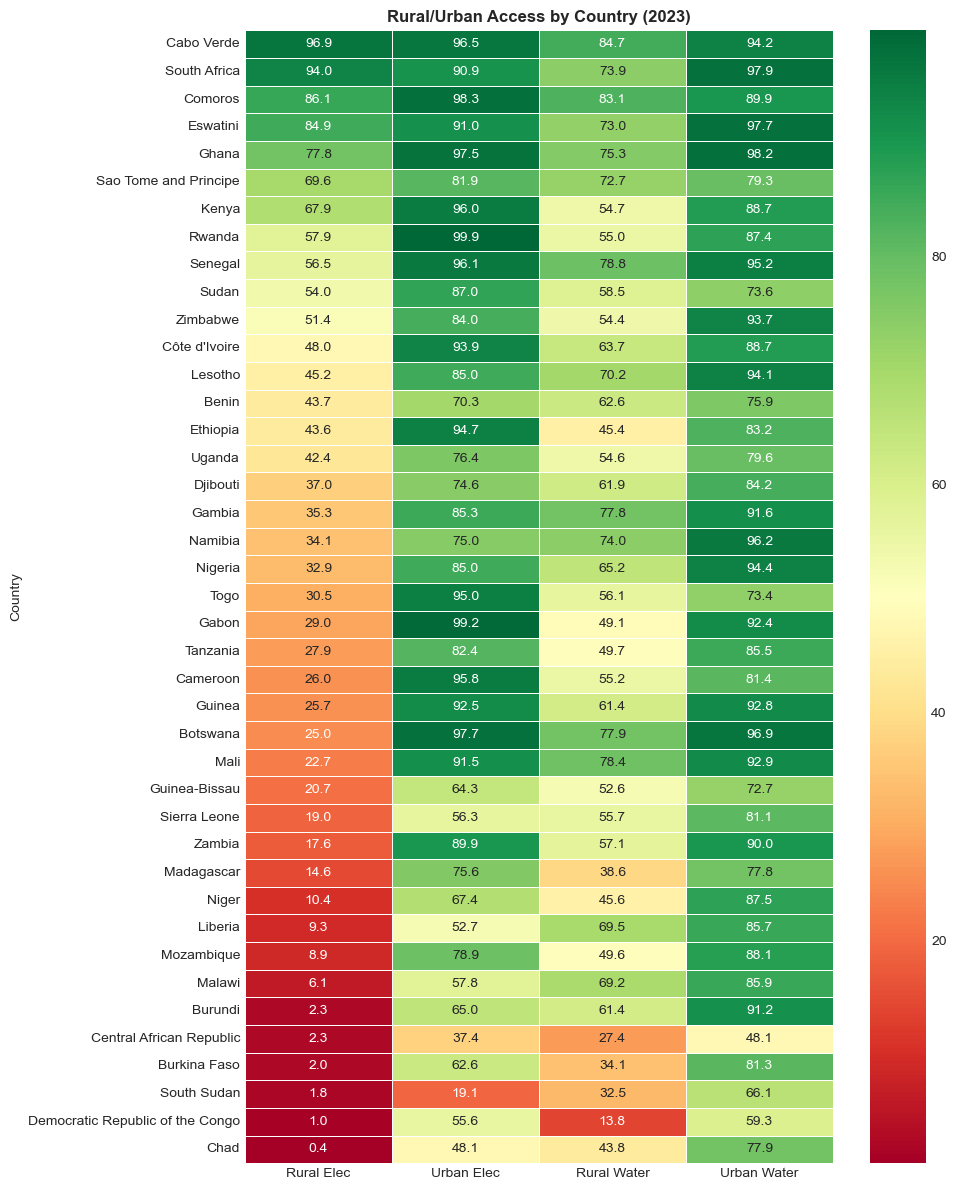

In [24]:
# Heatmap by country for latest year
df_country_heatmap = df_corr[df_corr['Year'] == latest_year][['Country', 'Elec_Rural', 'Elec_Urban', 'Water_Rural_Basic', 'Water_Urban_Basic']]
df_country_heatmap = df_country_heatmap.set_index('Country')
df_country_heatmap = df_country_heatmap.sort_values('Elec_Rural', ascending=False)

fig, ax = plt.subplots(figsize=(10, 12))
sns.heatmap(df_country_heatmap, annot=True, fmt='.1f', cmap='RdYlGn', center=50,
            linewidths=0.5, ax=ax,
            xticklabels=['Rural Elec', 'Urban Elec', 'Rural Water', 'Urban Water'])
ax.set_title(f'Rural/Urban Access by Country ({latest_year})', fontweight='bold')

plt.tight_layout()
plt.savefig('../csv/country_heatmap_all_indicators.png', dpi=150, bbox_inches='tight')
plt.show()

---
# 7. Key Findings <a id='7-findings'></a>

In [25]:
# Compile key findings
print("=" * 70)
print("KEY FINDINGS SUMMARY")
print("=" * 70)

# Electricity findings
elec_latest = df_analysis[df_analysis['Year'] == latest_year]
print(f"\n1. ELECTRICITY ACCESS ({latest_year})")
print(f"   - Rural average: {elec_latest['Elec_Rural'].mean():.1f}%")
print(f"   - Urban average: {elec_latest['Elec_Urban'].mean():.1f}%")
print(f"   - Urban-Rural gap: {elec_latest['Elec_Gap'].mean():.1f} percentage points")

# Water findings
water_latest = df_water_analysis[df_water_analysis['Year'] == latest_year]
if len(water_latest) > 0:
    print(f"\n2. WATER ACCESS ({latest_year})")
    print(f"   - Rural average: {water_latest['Water_Rural_Basic'].mean():.1f}%")
    print(f"   - Urban average: {water_latest['Water_Urban_Basic'].mean():.1f}%")
    print(f"   - Urban-Rural gap: {water_latest['Water_Gap'].mean():.1f} percentage points")

# Correlation findings
print(f"\n3. CORRELATIONS")
r_rural, _ = stats.pearsonr(df_corr['Elec_Rural'], df_corr['Water_Rural_Basic'])
r_urban, _ = stats.pearsonr(df_corr['Elec_Urban'], df_corr['Water_Urban_Basic'])
r_gap, _ = stats.pearsonr(df_corr['Elec_Gap'], df_corr['Water_Gap'])
print(f"   - Rural Electricity vs Rural Water: r = {r_rural:.3f}")
print(f"   - Urban Electricity vs Urban Water: r = {r_urban:.3f}")
print(f"   - Electricity Gap vs Water Gap: r = {r_gap:.3f}")

KEY FINDINGS SUMMARY

1. ELECTRICITY ACCESS (2023)
   - Rural average: 37.2%
   - Urban average: 80.0%
   - Urban-Rural gap: 42.8 percentage points

2. WATER ACCESS (2023)
   - Rural average: 58.5%
   - Urban average: 85.1%
   - Urban-Rural gap: 26.6 percentage points

3. CORRELATIONS
   - Rural Electricity vs Rural Water: r = 0.656
   - Urban Electricity vs Urban Water: r = 0.527
   - Electricity Gap vs Water Gap: r = 0.392


---
# 8. Conclusion <a id='8-conclusion'></a>

## 8.1 Summary of Data Analysis

This analysis examined the relationship between electricity access and water access in Sub-Saharan Africa, with a focus on rural vs urban differences.

## 8.2 Data Limitations

- Dataset contains only percentage values
- Different data sources (World Bank, JMP) may have different methodologies
- Some countries have missing data
- Correlation does not imply causation

---

*Data Sources: World Bank WDI (EG.ELC.ACCS.RU.ZS, EG.ELC.ACCS.UR.ZS), WHO/UNICEF JMP*